<a href="https://colab.research.google.com/github/ekoome/convolutions/blob/main/Notebooks/Chap10/10_2_Convolution_for_MNIST_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 10.2: Convolution for MNIST-1D**

This notebook investigates a 1D convolutional network for MNIST-1D as in figure 10.7 and 10.8a.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.



In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-lap6c780
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-lap6c780
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14664 sha256=d31baf7f43f327d799bd51877d3c2386b29eb44622eef79c385ffb15388a131e
  Stored in directory: /tmp/pip-ephem-wheel-cache-bk3jhxsu/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d


In [2]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [4]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


Number of training examples: 4000
Dimensions of each training example (input features): 40
Range of values in training input data (min): -5.48
Range of values in training input data (max): 4.53
Unique labels in training data: [0 1 2 3 4 5 6 7 8 9]
Counts of each label: [398 396 411 394 394 402 401 404 402 398]


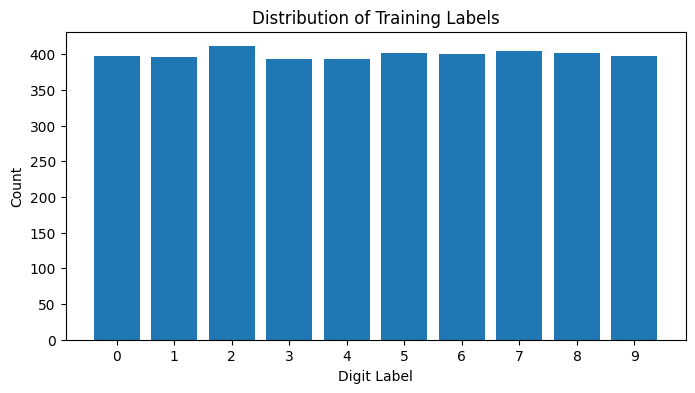

In [9]:
# Summarize the training data
print(f"Number of training examples: {len(train_data_y)}")
print(f"Dimensions of each training example (input features): {train_data_x.shape[0]}")
print(f"Range of values in training input data (min): {train_data_x.min():.2f}")
print(f"Range of values in training input data (max): {train_data_x.max():.2f}")

# Get unique labels and their counts
unique_labels, label_counts = np.unique(train_data_y, return_counts=True)
print(f"Unique labels in training data: {unique_labels}")
print(f"Counts of each label: {label_counts}")

plt.figure(figsize=(8, 4))
plt.bar(unique_labels, label_counts)
plt.title('Distribution of Training Labels')
plt.xlabel('Digit Label')
plt.ylabel('Count')
plt.xticks(unique_labels)
plt.show()

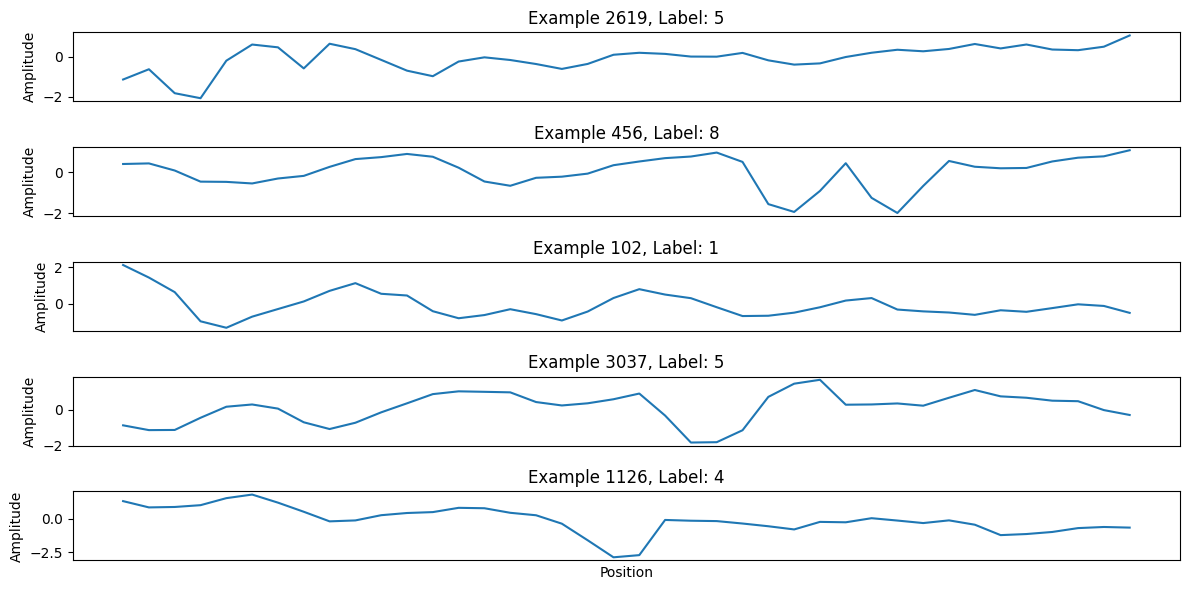

In [8]:
import matplotlib.pyplot as plt

# Let's visualize a few examples from the training data
num_examples_to_plot = 5

plt.figure(figsize=(12, 6))
for i in range(num_examples_to_plot):
    # Select a random index
    idx = random.randint(0, len(train_data_y) - 1)

    plt.subplot(num_examples_to_plot, 1, i + 1)
    plt.plot(train_data_x[:, idx])
    plt.title(f"Example {idx}, Label: {train_data_y[idx]}")
    plt.ylabel('Amplitude')
    plt.xticks([]) # Hide x-axis ticks for cleaner visualization

plt.xlabel('Position')
plt.tight_layout()
plt.show()

Define the network

In [5]:
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10


# TODO Create a model with the following layers
# 1. Convolutional layer, (input=length 40 and 1 channel, kernel size 3, stride 2, padding="valid", 15 output channels )
# 2. ReLU
# 3. Convolutional layer, (input=length 19 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels )
# 4. ReLU
# 5. Convolutional layer, (input=length 9 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels)
# 6. ReLU
# 7. Flatten (converts 4x15) to length 60
# 8. Linear layer (input size = 60, output size = 10)
# References:
# https://pytorch.org/docs/1.13/generated/torch.nn.Conv1d.html?highlight=conv1d#torch.nn.Conv1d
# https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html
# https://pytorch.org/docs/1.13/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear

# NOTE THAT THE CONVOLUTIONAL LAYERS NEED TO TAKE THE NUMBER OF INPUT CHANNELS AS A PARAMETER
# AND NOT THE INPUT SIZE.

# Replace the following function:
model = nn.Sequential(
nn.Flatten(),
nn.Linear(40, 100),
nn.ReLU(),
nn.Linear(100, 100),
nn.ReLU(),
nn.Linear(100, 10))





In [6]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

Epoch     0, train loss 1.587801, train error 61.85,  val loss 1.652297, percent error 66.40
Epoch     1, train loss 1.371501, train error 51.97,  val loss 1.504340, percent error 62.70
Epoch     2, train loss 1.204795, train error 43.78,  val loss 1.421079, percent error 56.50
Epoch     3, train loss 1.038989, train error 36.75,  val loss 1.300813, percent error 51.80
Epoch     4, train loss 0.959543, train error 35.07,  val loss 1.256903, percent error 50.50
Epoch     5, train loss 0.820138, train error 28.40,  val loss 1.171354, percent error 46.40
Epoch     6, train loss 0.750684, train error 26.68,  val loss 1.158008, percent error 44.90
Epoch     7, train loss 0.671425, train error 23.82,  val loss 1.155816, percent error 43.10
Epoch     8, train loss 0.621575, train error 20.85,  val loss 1.133243, percent error 42.90
Epoch     9, train loss 0.529375, train error 18.03,  val loss 1.117888, percent error 41.30
Epoch    10, train loss 0.480226, train error 16.00,  val loss 1.17407

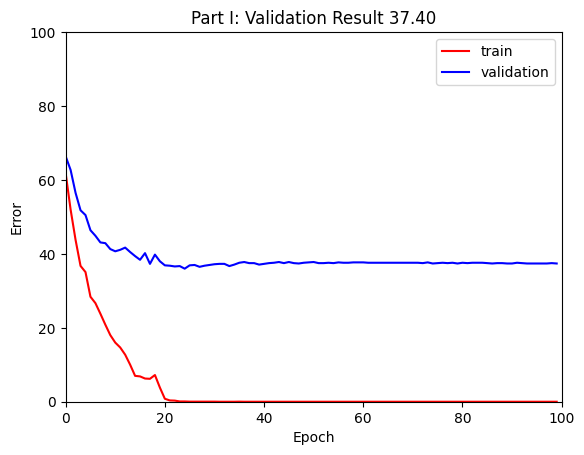

In [7]:
# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long')).long()
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long')).long()

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 100
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch[:,None,:])
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train[:,None,:])
  pred_val = model(x_val[:,None,:])
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val[-1]))
ax.legend()
plt.show()